## Models Notebook
#### This notebook holds the FSM with iterations and different models as well as evaluation. I chose to use Sci-Kit Learn's Dummy Classifier as baseline and improve from there. 
- The models are being optimized for recall, limiting the amount of false negatives. In this context, limiting the amount of PED cases classified as not positive when they are.
#### Models Evaluation
- Stratified Kfold Cross Validation with recall scoring in order to preserve the percentage of samples in the target class as the dataset as a whole.
- ROC-AUC Curve to show how well the model is performing at distinguishing positive from negative PED use cases.
- Confusion Matrix to gain insight on the amount of False Positive, True Positives, False Negatives, and False Positives.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Loading in libraries for data preprocessing, modeling, and evaluation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from Olympic_PED_use.src import functions as fn

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
import xgboost as xgb
import eli5
sns.set(font_scale=1.6)

In [3]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [71]:
df = pd.read_csv('../data/model_df_5.csv', low_memory=False)

#### Defining continuous and categorical features to be scaled and encoded

In [72]:
df = df.drop(['name', 'noc', 'games', 'season',
            'sport', 'team', 'city'], axis=1)

In [73]:
df.columns[8:161]

Index(['mens_100m_04', 'mens_100m_08', 'mens_100m_12', 'mens_100m_16', 'mens_200m_04', 'mens_200m_08', 'mens_200m_12', 'mens_200m_16', 'mens_400m_04', 'mens_400m_08',
       ...
       'womens_long_08', 'womens_long_12', 'womens_long_16', 'womens_high_04', 'womens_high_08', 'womens_high_12', 'womens_triple_04', 'womens_triple_08', 'womens_triple_12', 'womens_triple_16'], dtype='object', length=153)

In [74]:
cont_features =  list(df.columns[8:161])
cont_features.extend(['height', 'weight', 'age'])
cat_features = ['sex', 'year', 'medal', 'event']

In [75]:
df.flagged.value_counts()
pivot_flagged = df.pivot_table(index='flagged', values='event', aggfunc='count')
pivot_flagged

,event
flagged,
0.0,2462
1.0,245


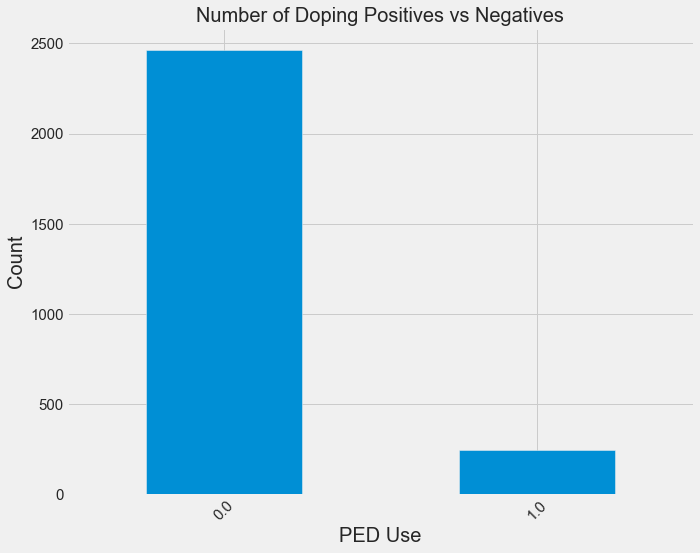

In [76]:
plt.style.use('fivethirtyeight')
plt.figure.figsize=(10,8)
pivot_flagged.plot(kind='bar', figsize=(10,8), fontsize=15, rot=45)
plt.xlabel('PED Use', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Number of Doping Positives vs Negatives', fontsize=20)
plt.legend().remove()

## Pipeline
#### Creating a pipeline to preprocess the data and fit a dummy classifier

In [77]:
cont_transformer = Pipeline(steps=[('ss', StandardScaler())])
cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(
        transformers=[
            ('cont', cont_transformer, cont_features),
             ('cat', cat_transformer, cat_features)])

baseline_pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', DummyClassifier())])

In [78]:
from sklearn import set_config
set_config(display='diagram')
baseline_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['mens_100m_04',
                                                   'mens_100m_08',
                                                   'mens_100m_12',
                                                   'mens_100m_16',
                                                   'mens_200m_04',
                                                   'mens_200m_08',
                                                   'mens_200m_12',
                                                   'mens_200m_16',
                                                   'mens_400m_04',
                                                   'mens_400m_08',
                                                   'mens_400m_12',
                                                   'mens_400m_16',
                                                   'mens_800m_04',
                                                   'mens_800m_08',
                                                   'mens_800m_12',
                                                   'mens_800m_16',
                                                   'mens_1500m_04',
                                                   'mens_1500m_08',
                                                   'mens_1500m_12',
                                                   'mens_1500m_16',
                                                   'mens_5000m_04',
                                                   'mens_5000m_08',
                                                   'mens_5000m_12',
                                                   'mens_5000m_16',
                                                   'mens_110H_04',
                                                   'mens_110H_08',
                                                   'mens_110H_12',
                                                   'mens_110H_16',
                                                   'mens_400H_04',
                                                   'mens_400H_08', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'year', 'medal',
                                                   'event'])])),
                ('classifier', DummyClassifier())])

#### Defining target and predictor variables and performing two train test splits for a hold out test set to evaluate the best model on.

In [79]:
X = df.drop('flagged', axis=1)
y = df.flagged
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## FSM: Dummy Classifier

#### Fitting the pipeline and cross validating with the validation set created from the training data. Using Stratified Kfold to preserve the distribution of positive and negative PED classes. The validation set will be used to help fine tune the models. I am optimizing for recall to limit the amount of false negatives, athletes classified as not positive for PED use when in fact they are positive.

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       370
           1       0.16      0.14      0.15        36

    accuracy                           0.86       406
   macro avg       0.54      0.53      0.54       406
weighted avg       0.85      0.86      0.85       406

Recall:  0.1388888888888889
Accuracy:  0.8596059113300493
Precision:  0.16129032258064516
F1:  0.14925373134328357


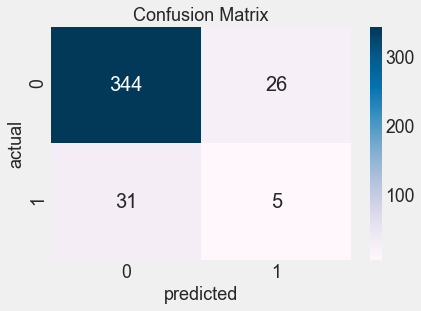

None
0.8368226600985222
0.845320197044335


In [80]:
cv = StratifiedKFold()
fsm_train_acc = []
fsm_test_acc = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    bp = baseline_pipe
    bp.fit(X_t, y_t)
    y_hat_t = bp.predict(X_t)
    
    fsm_train_acc.append(accuracy_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = bp.predict(X_val)
    
    fsm_test_acc.append(accuracy_score(y_val, y_hat_val))
print(fn.evaluation(y_val, y_hat_val))
print(np.mean(fsm_train_acc))
print(np.mean(fsm_test_acc))

In [81]:
fsm_fpr, fsm_tpr, thresholds = roc_curve(y_val, y_hat_val)
fsm_roc_auc = auc(fsm_fpr, fsm_tpr)
fsm_roc_auc

0.5343093093093093

### Evaluation
- The dummy classifier is not performing very well at classifying the positive class. This is due to the default strategy parameter 'stratified', which classifies by the class distribution of the training set.
- A recall score of approximately 22% indicates that out of all positive PED use cases, the model correctly classified 22% of them as positive cases.
- A roc-auc score of 55% indicating the model is not performing very well at distinguishing the positive from the negative classes.

## Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       370
           1       0.63      0.72      0.68        36

    accuracy                           0.94       406
   macro avg       0.80      0.84      0.82       406
weighted avg       0.94      0.94      0.94       406

Recall:  0.7222222222222222
Accuracy:  0.9384236453201971
Precision:  0.6341463414634146
F1:  0.6753246753246753


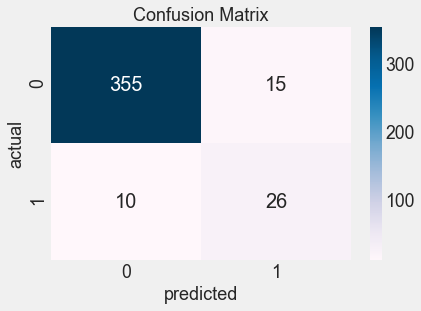

None
Average training accuracy: 
 1.0
Average validation accuracy: 
 0.9266009852216749
Average training recall: 
 1.0
Average validation recall: 
 0.5822822822822824


In [82]:
dtree_pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', DecisionTreeClassifier())])
cv = StratifiedKFold()
dtree_train_acc = []
dtree_test_acc = []
dtree_train_recall = []
dtree_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    dp = dtree_pipe
    dp.fit(X_t, y_t)
    y_hat_t = dp.predict(X_t)
    
    dtree_train_acc.append(accuracy_score(y_t, y_hat_t))
    dtree_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = dp.predict(X_val)
    
    dtree_test_acc.append(accuracy_score(y_val, y_hat_val))
    dtree_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(dtree_train_acc))
print('Average validation accuracy: \n', np.mean(dtree_test_acc))
print('Average training recall: \n', np.mean(dtree_train_recall))
print('Average validation recall: \n', np.mean(dtree_test_recall))

In [83]:
dtree_fpr, dtree_tpr, thresholds = roc_curve(y_val, dp.predict(X_val))
roc_auc = auc(dtree_fpr, dtree_tpr)
roc_auc

0.8408408408408409

### Evaluation
- The decision tree classifier with default parameters performed significantly better than the dummy classifier with an increased recall score of 88%. The dummy classifier had a recall score of 10%.
- This model produced a average cross val recall score of 87%
- A ROC-AUC score of 95%, indicating the model is performing well at distinguishing the positive from the negative PED use classes.
- An average training recall is higher than the validation recall, indicating this model is overfit.

### Grid Search with Decision Tree

In [84]:
dtree_params = {'classifier__max_depth': [5, 7, 10, 15, 25, 40, 80, 120],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__min_samples_split':[2, 4, 6, 10, 15, 20, 40],
              'classifier__min_samples_leaf': [1, 2, 4, 7, 12],
              'classifier__random_state': [42]}


Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2769 out of 2800 | elapsed:   18.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   18.6s finished


Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2769 out of 2800 | elapsed:   19.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   20.0s finished


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       370
           1       0.62      0.72      0.67        36

    accuracy                           0.94       406
   macro avg       0.80      0.84      0.82       406
weighted avg       0.94      0.94      0.94       406

Recall:  0.7222222222222222
Accuracy:  0.9359605911330049
Precision:  0.6190476190476191
F1:  0.6666666666666666


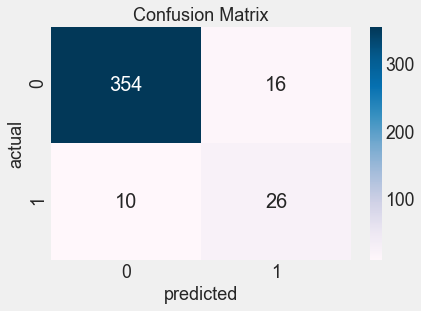

None
Average training accuracy: 
 0.9980295566502463
Average validation accuracy: 
 0.9315270935960591
Average training recall: 
 0.981081081081081
Average validation recall: 
 0.6255255255255256


In [85]:
grid_search = GridSearchCV(dtree_pipe, dtree_params, scoring='recall',
                          cv=cv, n_jobs=-1, verbose=2)

cv = StratifiedKFold()
dtree_train_acc = []
dtree_test_acc = []
dtree_train_recall = []
dtree_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    grid_dp = grid_search
    grid_dp.fit(X_t, y_t)
    y_hat_t = grid_dp.predict(X_t)
    
    dtree_train_acc.append(accuracy_score(y_t, y_hat_t))
    dtree_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = grid_dp.predict(X_val)
    
    dtree_test_acc.append(accuracy_score(y_val, y_hat_val))
    dtree_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(dtree_train_acc))
print('Average validation accuracy: \n', np.mean(dtree_test_acc))
print('Average training recall: \n', np.mean(dtree_train_recall))
print('Average validation recall: \n', np.mean(dtree_test_recall))

In [86]:
grid_search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 25,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 4,
 'classifier__random_state': 42}

In [87]:
dtree_grid_fpr, dtree_grid_tpr, thresholds = roc_curve(y_val, grid_dp.predict(X_val))
dtree_grid_roc_auc = auc(dtree_grid_fpr, dtree_grid_tpr)
dtree_grid_roc_auc

0.8394894894894895

#### After running a grid search with the decision tree classifier, I was able to achieve an improvement in the average recall validation by about 10% and the roc-auc score also increased by 1%. The model is still performing better on the training than the validation indicating the model is still overfit.

## Random Forest Classifier

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       370
           1       1.00      0.69      0.82        36

    accuracy                           0.97       406
   macro avg       0.99      0.85      0.90       406
weighted avg       0.97      0.97      0.97       406

Recall:  0.6944444444444444
Accuracy:  0.9729064039408867
Precision:  1.0
F1:  0.819672131147541


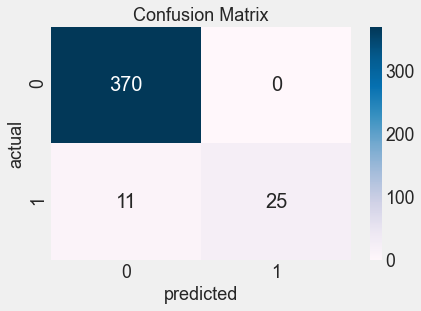

None
Average training accuracy: 
 0.9998768472906404
Average validation accuracy: 
 0.9586206896551724
Average training recall: 
 0.9986486486486486
Average validation recall: 
 0.5767267267267269


In [88]:
rf_pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', RandomForestClassifier())])

cv = StratifiedKFold()
rf_train_acc = []
rf_test_acc = []
rf_train_recall = []
rf_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    rp = rf_pipe
    rp.fit(X_t, y_t)
    y_hat_t = rp.predict(X_t)
    
    rf_train_acc.append(accuracy_score(y_t, y_hat_t))
    rf_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = rp.predict(X_val)
    
    rf_test_acc.append(accuracy_score(y_val, y_hat_val))
    rf_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(rf_train_acc))
print('Average validation accuracy: \n', np.mean(rf_test_acc))
print('Average training recall: \n', np.mean(rf_train_recall))
print('Average validation recall: \n', np.mean(rf_test_recall))

In [89]:
rf_fpr, rf_tpr, thresholds = roc_curve(y_val, rp.predict(X_val))
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.8472222222222222

### Evaluation
- The Random Forest Classifier performed pretty well with the default parameters with an average validation recall score of 83%
- The model did not misclassify any negative PED use cases
- The Random Forest Classifier produced an roc-auc score of 92%, slightly lower than the Decision Tree Classifier but not by much.

### 

#### Next I wil check the feature importances of the model

In [90]:
onehot_columns = list(rf_pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe'].get_feature_names(input_features=cat_features))
numeric_features_list = list(cont_features)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(rf_pipe.named_steps['classifier'], top=30, feature_names=numeric_features_list)

Weight,Feature
0.1181 ± 0.0826,height
0.1019 ± 0.0724,age
0.0976 ± 0.0687,weight
0.0438 ± 0.0831,womens_100m_08
0.0345 ± 0.0746,womens_200m_12
0.0337 ± 0.0849,womens_100m_04
0.0266 ± 0.0619,medal_1.0
0.0252 ± 0.0816,womens_100m_16
0.0252 ± 0.0391,year_2008
0.0200 ± 0.0307,mens_100m_12


In [91]:
df.corr()['height'][:5].sort_values(ascending=False)

height    1.000000
weight    0.751720
sex       0.644884
age       0.095928
year     -0.039690
Name: height, dtype: float64

#### The graphic above shows that height, weight, sex are the top 3 most important features to the model. This makes sense because these three features currently hold the most data on the athletes. The event results that were merged to the dataframe containing this information had different spellings and puctuation. I was able to use fuzzy wuzzy and find partial matches to names and change them but there were still many athletes that I was not able to find a match on.

### Grid Search for Random Forest Classifier

In [94]:
param_grid = {'classifier__n_estimators': [100, 300, 500, 800],
              'classifier__max_depth':[6, 25, 50, 70],
              'classifier__min_samples_split': [2, 5, 10, 15],
              'classifier__min_samples_leaf': [1, 2, 5, 10]}

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:   50.7s finished


Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:   57.7s finished


Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:   58.8s finished


Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  1.0min finished


Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  1.0min finished


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       370
           1       1.00      0.72      0.84        36

    accuracy                           0.98       406
   macro avg       0.99      0.86      0.91       406
weighted avg       0.98      0.98      0.97       406

Recall:  0.7222222222222222
Accuracy:  0.9753694581280788
Precision:  1.0
F1:  0.8387096774193548


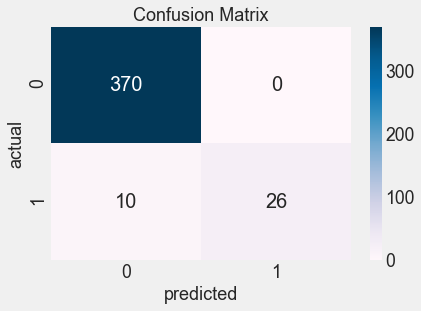

None
Average training accuracy: 
 1.0
Average validation accuracy: 
 0.9596059113300492
Average training recall: 
 1.0
Average validation recall: 
 0.5930930930930931


In [95]:
rf_grid_search = GridSearchCV(rf_pipe, param_grid, 
                             n_jobs=-1, scoring='recall', 
                             cv=2, refit=True, verbose=2)

cv = StratifiedKFold()
rf_train_acc = []
rf_test_acc = []
rf_train_recall = []
rf_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    grid_rp = rf_grid_search
    grid_rp.fit(X_t, y_t)
    y_hat_t = grid_rp.predict(X_t)
    
    rf_train_acc.append(accuracy_score(y_t, y_hat_t))
    rf_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = grid_rp.predict(X_val)
    
    rf_test_acc.append(accuracy_score(y_val, y_hat_val))
    rf_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(rf_train_acc))
print('Average validation accuracy: \n', np.mean(rf_test_acc))
print('Average training recall: \n', np.mean(rf_train_recall))
print('Average validation recall: \n', np.mean(rf_test_recall))

In [96]:
rf_grid_search.best_params_

{'classifier__max_depth': 70,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 500}

In [97]:
grid_rf_fpr, grid_rf_tpr, thresholds = roc_curve(y_val, grid_rp.predict(X_val))
rf_roc_auc = auc(grid_rf_fpr, grid_rf_tpr)
rf_roc_auc

0.8611111111111112

### Evaluation
- The Grid Search did not improve the model as much as I would have liked. The scores are very close to the Random Forest Classifier with default parameters.
- The roc-auc of this model increased slightly by 2% than the random forest classifier using default parameters.

## XGBoost Classifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       370
           1       0.90      0.75      0.82        36

    accuracy                           0.97       406
   macro avg       0.94      0.87      0.90       406
weighted avg       0.97      0.97      0.97       406

Recall:  0.75
Accuracy:  0.9704433497536946
Precision:  0.9
F1:  0.8181818181818182


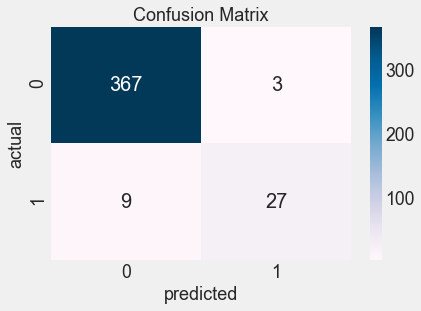

None
Average training accuracy: 
 0.9903940886699507
Average validation accuracy: 
 0.9551724137931036
Average training recall: 
 0.8940246368817798
Average validation recall: 
 0.6148648648648649


In [98]:
xg_pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', xgb.XGBClassifier())])

cv = StratifiedKFold()
xg_train_acc = []
xg_test_acc = []
xg_train_recall = []
xg_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    xp = xg_pipe
    xp.fit(X_t, y_t)
    y_hat_t = xp.predict(X_t)
    
    xg_train_acc.append(accuracy_score(y_t, y_hat_t))
    xg_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = xp.predict(X_val)
    
    xg_test_acc.append(accuracy_score(y_val, y_hat_val))
    xg_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(xg_train_acc))
print('Average validation accuracy: \n', np.mean(xg_test_acc))
print('Average training recall: \n', np.mean(xg_train_recall))
print('Average validation recall: \n', np.mean(xg_test_recall))

In [99]:
xg_fpr, xg_tpr, thresholds = roc_curve(y_val, xp.predict(X_val))
xg_roc_auc = auc(xg_fpr, xg_tpr)
xg_roc_auc

0.870945945945946

## Evaluation
- This model performed similarly to the Decision Tree and Random Forest Classifiers.
- The training and validation accuracy are close but the recall is off by around 9%.
- An roc-auc score of around 91% is also similar to the previous classifiers.

## K Neighbors Classifier

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       370
           1       0.86      0.53      0.66        36

    accuracy                           0.95       406
   macro avg       0.91      0.76      0.81       406
weighted avg       0.95      0.95      0.95       406

Recall:  0.5277777777777778
Accuracy:  0.9507389162561576
Precision:  0.8636363636363636
F1:  0.6551724137931034


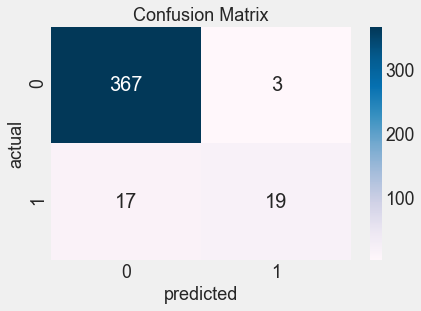

None
Average training accuracy: 
 0.9479064039408867
Average validation accuracy: 
 0.9334975369458128
Average training recall: 
 0.5163633020775877
Average validation recall: 
 0.46771771771771775


In [100]:
knn_pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', KNeighborsClassifier())])

cv = StratifiedKFold()
knn_train_acc = []
knn_test_acc = []
knn_train_recall = []
knn_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    kp = knn_pipe
    kp.fit(X_t, y_t)
    y_hat_t = kp.predict(X_t)
    
    knn_train_acc.append(accuracy_score(y_t, y_hat_t))
    knn_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = kp.predict(X_val)
    
    knn_test_acc.append(accuracy_score(y_val, y_hat_val))
    knn_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(knn_train_acc))
print('Average validation accuracy: \n', np.mean(knn_test_acc))
print('Average training recall: \n', np.mean(knn_train_recall))
print('Average validation recall: \n', np.mean(knn_test_recall))

In [101]:
knn_fpr, knn_tpr, thresholds = roc_curve(y_val, kp.predict(X_val))
knn_roc_auc = auc(knn_fpr, knn_tpr)
knn_roc_auc

0.7598348348348347

### Evaluation
- The K Neighbors Classifier did not perform as well as the classifiers above. It achieved an average recall score of 75% on the validation set.
- This model achieved a roc-auc score of 88%, also slightly lower than the other classifiers.

## Pipeline with SMOTE oversampling
#### In each fold the pipeline will:
- overample the minority class
- train the classifier on the training folds
- validate on the remaining fold

In [102]:
smote = SMOTE(random_state=42)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       370
           1       1.00      0.78      0.88        36

    accuracy                           0.98       406
   macro avg       0.99      0.89      0.93       406
weighted avg       0.98      0.98      0.98       406

Recall:  0.7777777777777778
Accuracy:  0.9802955665024631
Precision:  1.0
F1:  0.8750000000000001


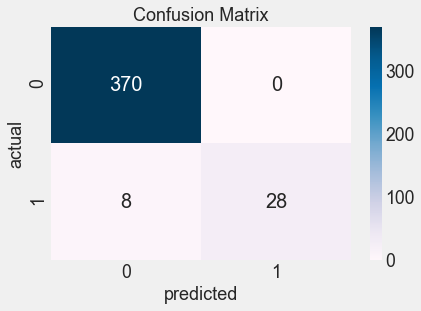

None
Average training accuracy: 
 1.0
Average validation accuracy: 
 0.9615763546798031
Average training recall: 
 1.0
Average validation recall: 
 0.6420420420420421


In [103]:
rf_pipe_smote = Pipeline(steps=[('preprocess', preprocessor),
                          ('smote', smote),
                       ('classifier', RandomForestClassifier(random_state=42))])

cv = StratifiedKFold()
rf_smote_train_acc = []
rf_smote_test_acc = []
rf_smote_train_recall = []
rf_smote_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    srp = rf_pipe_smote
    srp.fit(X_t, y_t)
    y_hat_t = srp.predict(X_t)
    
    rf_smote_train_acc.append(accuracy_score(y_t, y_hat_t))
    rf_smote_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = srp.predict(X_val)
    
    rf_smote_test_acc.append(accuracy_score(y_val, y_hat_val))
    rf_smote_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(rf_smote_train_acc))
print('Average validation accuracy: \n', np.mean(rf_smote_test_acc))
print('Average training recall: \n', np.mean(rf_smote_train_recall))
print('Average validation recall: \n', np.mean(rf_smote_test_recall))

In [104]:
smote_rf_fpr, smote_rf_tpr, thresholds = roc_curve(y_val, srp.predict(X_val))
smote_rf_roc_auc = auc(smote_rf_fpr, smote_rf_tpr)
smote_rf_roc_auc

0.8888888888888888

### Evaluation
- This performed pretty well after oversampling with smote. It achieved an average recall score of 84% on the validation set. The training accuracy and validation were both at 100%, the validation accuracy is close at 98% but the recall is still off by around 16%.
- The roc-auc did not change very much from the Random Forest Classifier with the default parameters.

## XGBoost Classifier in SMOTE pipeline

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       370
           1       0.79      0.75      0.77        36

    accuracy                           0.96       406
   macro avg       0.88      0.87      0.87       406
weighted avg       0.96      0.96      0.96       406

Recall:  0.75
Accuracy:  0.9605911330049262
Precision:  0.7941176470588235
F1:  0.7714285714285715


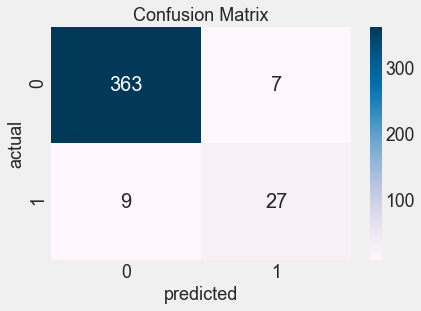

None
Average training accuracy: 
 0.9917487684729064
Average validation accuracy: 
 0.9502463054187192
Average training recall: 
 0.9089906232763376
Average validation recall: 
 0.6310810810810811


In [105]:
xg_smote_pipe = Pipeline(steps=[('preprocess', preprocessor),
                                ('smote', smote),
                                ('classifier', xgb.XGBClassifier())])

cv = StratifiedKFold()
xg_smote_train_acc = []
xg_smote_test_acc = []
xg_smote_train_recall = []
xg_smote_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    sxg = xg_smote_pipe
    sxg.fit(X_t, y_t)
    y_hat_t = sxg.predict(X_t)
    
    xg_smote_train_acc.append(accuracy_score(y_t, y_hat_t))
    xg_smote_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = sxg.predict(X_val)
    
    xg_smote_test_acc.append(accuracy_score(y_val, y_hat_val))
    xg_smote_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(xg_smote_train_acc))
print('Average validation accuracy: \n', np.mean(xg_smote_test_acc))
print('Average training recall: \n', np.mean(xg_smote_train_recall))
print('Average validation recall: \n', np.mean(xg_smote_test_recall))

In [106]:
smote_xg_fpr, smote_xg_tpr, thresholds = roc_curve(y_val, sxg.predict(X_val))
smote_xg_roc_auc = auc(smote_xg_fpr, smote_xg_tpr)
smote_xg_roc_auc

0.8655405405405405

## Evaluation
- The XGBoost Classifier trained on SMOTE oversampled data performed well achieving a average recall score of 84% on the validation set.
- The roc-auc score for this model was 91%

### XGBoost with Random Undersampling

In [145]:
under = RandomUnderSampler(.2, random_state=42)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       370
           1       0.76      0.81      0.78        36

    accuracy                           0.96       406
   macro avg       0.87      0.89      0.88       406
weighted avg       0.96      0.96      0.96       406

Recall:  0.8055555555555556
Accuracy:  0.9605911330049262
Precision:  0.7631578947368421
F1:  0.7837837837837838


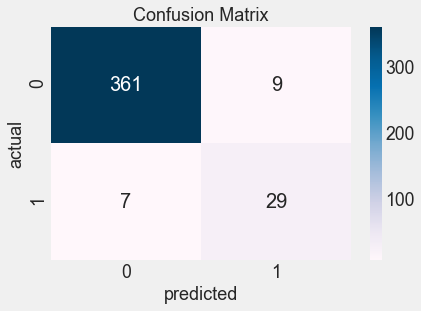

None
Average training accuracy: 
 0.9839901477832512
Average validation accuracy: 
 0.9394088669950739
Average training recall: 
 0.9470123184408898
Average validation recall: 
 0.653003003003003


In [146]:
xg_under_pipe = Pipeline(steps=[('preprocess', preprocessor),
                                ('under', under),
                                ('classifier', xgb.XGBClassifier())])

cv = StratifiedKFold()
xg_under_train_acc = []
xg_under_test_acc = []
xg_under_train_recall = []
xg_under_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    uxg = xg_under_pipe
    uxg.fit(X_t, y_t)
    y_hat_t = uxg.predict(X_t)
    
    xg_under_train_acc.append(accuracy_score(y_t, y_hat_t))
    xg_under_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = uxg.predict(X_val)
    
    xg_under_test_acc.append(accuracy_score(y_val, y_hat_val))
    xg_under_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(xg_under_train_acc))
print('Average validation accuracy: \n', np.mean(xg_under_test_acc))
print('Average training recall: \n', np.mean(xg_under_train_recall))
print('Average validation recall: \n', np.mean(xg_under_test_recall))

In [148]:
under_xg_fpr, under_xg_tpr, thresholds = roc_curve(y_val, uxg.predict(X_val))
under_xg_roc_auc = auc(under_xg_fpr, under_xg_tpr)
under_xg_roc_auc

0.8906156156156156

## Evaluation
- The XGBoost Classifier trained on Random Undersampled data produced the best validation recall yet at 65%
- The auc-roc score of this classifier is also the highest at 89%

#### I am going to continue iterating over the XGBoost and Random Forest Classifiers. Next, I will try to add random undersampling to the pipeline with Random Forest.
- Setting the Random Under Sampling strategy to undersample 30% of the majority class

In [151]:
under = RandomUnderSampler(.2, random_state=42)

### Random Under Sampling on Random Forest

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       370
           1       0.93      0.75      0.83        36

    accuracy                           0.97       406
   macro avg       0.95      0.87      0.91       406
weighted avg       0.97      0.97      0.97       406

Recall:  0.75
Accuracy:  0.9729064039408867
Precision:  0.9310344827586207
F1:  0.8307692307692308


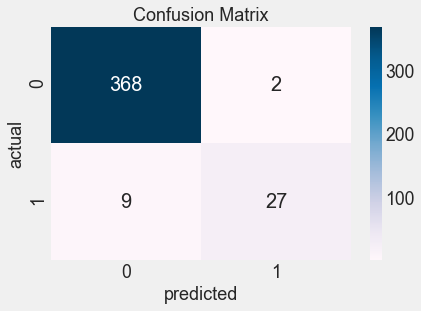

None
Average training accuracy: 
 0.9905172413793103
Average validation accuracy: 
 0.9517241379310345
Average training recall: 
 1.0
Average validation recall: 
 0.6148648648648649


In [153]:
rf_under_pipe = Pipeline(steps=[('preprocess', preprocessor),
                                ('under', under),
                                ('classifier', RandomForestClassifier())])

cv = StratifiedKFold()
rf_under_train_acc = []
rf_under_test_acc = []
rf_under_train_recall = []
rf_under_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    urp = rf_under_pipe
    urp.fit(X_t, y_t)
    y_hat_t = urp.predict(X_t)
    
    rf_under_train_acc.append(accuracy_score(y_t, y_hat_t))
    rf_under_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = urp.predict(X_val)
    
    rf_under_test_acc.append(accuracy_score(y_val, y_hat_val))
    rf_under_test_recall.append(recall_score(y_val, y_hat_val))
    
print(fn.evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(rf_under_train_acc))
print('Average validation accuracy: \n', np.mean(rf_under_test_acc))
print('Average training recall: \n', np.mean(rf_under_train_recall))
print('Average validation recall: \n', np.mean(rf_under_test_recall))

In [155]:
under_rf_fpr, under_rf_tpr, thresholds = roc_curve(y_val, urp.predict(X_val))
under_rf_roc_auc = auc(under_rf_fpr, under_rf_tpr)
under_rf_roc_auc

0.8722972972972973

### Evaluation
- Random Forest with Random Undersampling performed similarly to the XGBoost Classifier with Random Undersampling.
- The validation accuracy is higher for Random Forest but the recall is lower as well as the roc-auc score.

### Grid Search with XGBoost Classifier, SMOTE oversampling.
- The two cells below were originally run without using the stratified KFold structure used above. The grid search took around 7 hours to run and did not improve the model's performance. 

In [46]:
xgb_param_grid = {
    "classifier__learning_rate": [0.5, 0.1, 0.01],
    'classifier__max_depth': [10, 20, 40, 60, 85],
    'classifier__gamma': [0.5, 1, 1.5, 2, 4],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [6, 8, 12, 18],
    'classifier__subsample': [ 0.2, 0.4, 0.8],
    'classifier__n_estimators': [30, 100, 325, 500, 700],
}

## Warning, cell below took around 7 hours to run.

In [ ]:
grid_xg_smote_pipe = Pipeline(steps=[('preprocess', preprocessor),
                                ('smote', smote),
                                ('classifier', xgb.XGBClassifier())])
xg_smote_grid_search = GridSearchCV(xg_smote_pipe, param_grid=xgb_param_grid,
                             n_jobs=-1, scoring='recall', 
                              refit=True, verbose=2)

cv = StratifiedKFold()
grid_xg_smote_train_acc = []
grid_xg_smote_test_acc = []
grid_xg_smote_train_recall = []
grid_xg_smote_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
    sxg_grid = xg_smote_grid_search
    sxg_grid.fit(X_t, y_t)
    y_hat_t = sxg_grid.predict(X_t)
    
    xg_smote_train_acc.append(accuracy_score(y_t, y_hat_t))
    xg_smote_train_recall.append(recall_score(y_t, y_hat_t))
    
    X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
    y_hat_val = sxg_grid.predict(X_val)
    
    xg_smote_test_acc.append(accuracy_score(y_val, y_hat_val))
    xg_smote_test_recall.append(recall_score(y_val, y_hat_val))
    
print('Average training accuracy: \n', np.mean(grid_xg_smote_train_acc))
print('Average validation accuracy: \n', np.mean(grid_xg_smote_test_acc))
print('Average training recall: \n', np.mean(grid_xg_smote_under_recall))
print('Average validation recall: \n', np.mean(grid_xg_smote_unde_recall))
smote_grid_xg_fpr, smote_grid_xg_tpr, thresholds = roc_curve(y_val, sxg_grid.predict(X_val))
smote_grid_xg_roc_auc = auc(smote_grid_xg_fpr, smote_grid_xg_tpr)
print('\nModel"s ROC-AUC score: \n', smote_grid_xg_roc_auc)

In [ ]:
smote_grid_xg_fpr, smote_grid_xg_tpr, thresholds = roc_curve(y_val, sxg_grid.predict(X_val))
smote_grid_xg_roc_auc = auc(smote_grid_xg_fpr, smote_grid_xg_tpr)
smote_grid_xg_roc_auc

### Evaluation
- Running the grid search with XGBoost did not improve the performance. The best estimator achieved an average recall score of 81% on the validation set.
- Successfully classifying 81% of the positive PED use cases is still not bad.
- The roc-auc also decreased from 94% to 91%

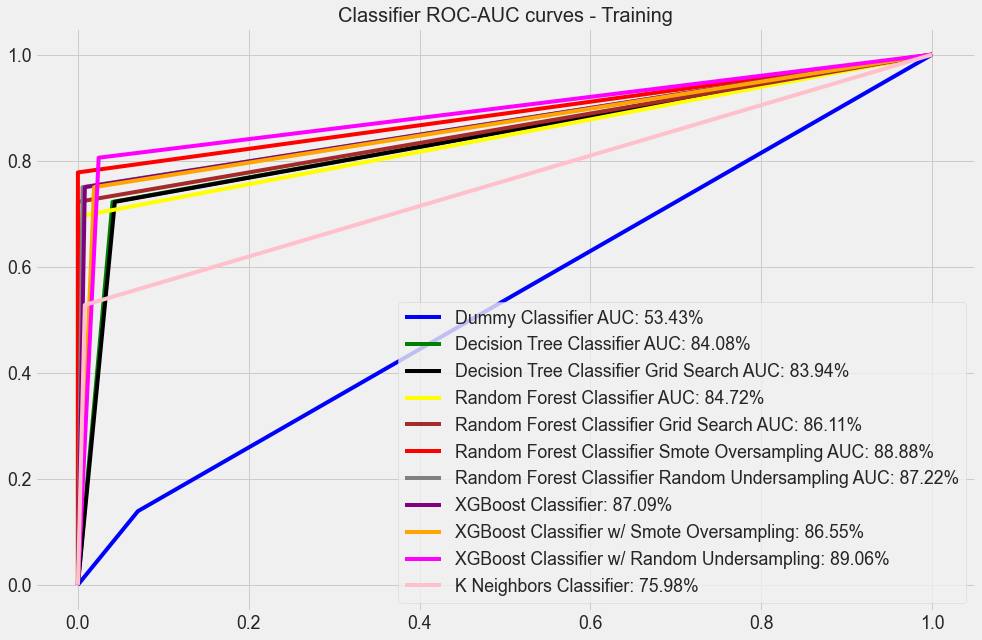

In [179]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))    
plt.plot(fsm_fpr, fsm_tpr, c='blue', label='Dummy Classifier AUC: 53.43%')
plt.plot(dtree_fpr, dtree_tpr, c='green', label='Decision Tree Classifier AUC: 84.08%')
plt.plot(dtree_grid_fpr, dtree_grid_tpr, c='black', label='Decision Tree Classifier Grid Search AUC: 83.94%')
plt.plot(rf_fpr, rf_tpr, c='yellow', label='Random Forest Classifier AUC: 84.72%')
plt.plot(grid_rf_fpr, grid_rf_tpr, c='brown', label='Random Forest Classifier Grid Search AUC: 86.11%')
plt.plot(smote_rf_fpr, smote_rf_tpr, c='red', label='Random Forest Classifier Smote Oversampling AUC: 88.88%')
plt.plot(under_rf_fpr, under_rf_tpr, c='grey', label='Random Forest Classifier Random Undersampling AUC: 87.22%')
plt.plot(xg_fpr, xg_tpr, c='purple', label='XGBoost Classifier: 87.09%')
plt.plot(smote_xg_fpr, smote_xg_tpr, c='orange', label='XGBoost Classifier w/ Smote Oversampling: 86.55%')
plt.plot(under_xg_fpr, under_xg_tpr, c='magenta', label='XGBoost Classifier w/ Random Undersampling: 89.06%')
plt.plot(knn_fpr, knn_tpr, c='pink', label='K Neighbors Classifier: 75.98%')
plt.title('Classifier ROC-AUC curves - Training', fontsize=20)
plt.legend(loc='best');
#plt.savefig('auc.png', bbox_inches='tight', transparent=True)

#### From the plot above it looks like the XGBoost Classifier produced the best roc-auc curve with 89.06% under the curve. This classifier also provided the best recall score on the validation set at 65% with the Random Forest Classifier trained on Smote oversampled data close at 64%.

## Evaluating the classifiers on the hold out test data

In [198]:
classifier_acc_scores = []
classifier_recall_scores = []
classifier_training_recall_scores = []
classifier_training_acc_scores = []
classifiers = ['DUMMY CLASSIFIER', 'DECISION TREE', 'DECISION TREE GRID SEARCH',
              'RANDOM FOREST', 'RANDOM FOREST GRID SEARCH', 'RANDOM FOREST SMOTE',
               'RANDOM FOREST RAND UNDER',
               'XGBOOST', 'XGB SMOTE', 'XGB RAND UNDER',
              'KNN']

### Dummy Classifier Evaluation

In [199]:
bp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, bp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, bp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, bp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, bp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, bp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, bp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, bp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, bp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, bp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, bp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, bp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, bp.predict(X_train)))


Testing Accuracy: 
 0.8463810930576071

Testing Precision: 
 0.06666666666666667

Testing Recall: 
 0.08196721311475409

Testing F1: 
 0.05594405594405595

Training Accuracy: 
 0.8330049261083744

Training Precision: 
 0.08284023668639054

Training Recall: 
 0.125

Training F1: 
 0.09497206703910614


### Decision Tree Classifer

In [200]:
dp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, dp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, dp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, dp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, dp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, dp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, dp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, dp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, dp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, dp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, dp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, dp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, dp.predict(X_train)))


Testing Accuracy: 
 0.9438700147710487

Testing Precision: 
 0.6825396825396826

Testing Recall: 
 0.7049180327868853

Testing F1: 
 0.6935483870967742

Training Accuracy: 
 1.0

Training Precision: 
 1.0

Training Recall: 
 1.0

Training F1: 
 1.0


### Decision Tree Classifier Grid Search CV

In [201]:
grid_dp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, grid_dp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, grid_dp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, grid_dp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, grid_dp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, grid_dp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, grid_dp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, grid_dp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, grid_dp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, grid_dp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, grid_dp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, grid_dp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, grid_dp.predict(X_train)))

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   47.6s finished



Testing Accuracy: 
 0.948301329394387

Testing Precision: 
 0.7166666666666667

Testing Recall: 
 0.7049180327868853

Testing F1: 
 0.7107438016528925

Training Accuracy: 
 1.0

Training Precision: 
 1.0

Training Recall: 
 1.0

Training F1: 
 1.0


### Random Forest Classifier

In [202]:
rp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, rp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, rp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, rp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, rp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, rp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, rp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, rp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, rp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, rp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, rp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, rp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, rp.predict(X_train)))


Testing Accuracy: 
 0.9689807976366323

Testing Precision: 
 0.9761904761904762

Testing Recall: 
 0.6721311475409836

Testing F1: 
 0.7961165048543689

Training Accuracy: 
 0.9995073891625615

Training Precision: 
 1.0

Training Recall: 
 0.9945652173913043

Training F1: 
 0.9972752043596731


### Random Forest Classifier Grid Search CV

In [203]:
grid_rp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, grid_rp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, grid_rp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, grid_rp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, grid_rp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, grid_rp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, grid_rp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, grid_rp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, grid_rp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, grid_rp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, grid_rp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, grid_rp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, grid_rp.predict(X_train)))

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  2.2min finished



Testing Accuracy: 
 0.9704579025110783

Testing Precision: 
 1.0

Testing Recall: 
 0.6721311475409836

Testing F1: 
 0.8039215686274509

Training Accuracy: 
 1.0

Training Precision: 
 1.0

Training Recall: 
 1.0

Training F1: 
 1.0


### Random Forest with Smote Oversampling

In [204]:
srp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, srp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, srp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, srp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, srp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, srp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, srp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, srp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, srp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, srp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, srp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, srp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, srp.predict(X_train)))


Testing Accuracy: 
 0.9675036927621861

Testing Precision: 
 0.9333333333333333

Testing Recall: 
 0.6885245901639344

Testing F1: 
 0.7924528301886792

Training Accuracy: 
 1.0

Training Precision: 
 1.0

Training Recall: 
 1.0

Training F1: 
 1.0


### Random Forest with Random Undersampling

In [205]:
urp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, urp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, urp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, urp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, urp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, urp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, urp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, urp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, urp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, urp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, urp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, urp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, urp.predict(X_train)))


Testing Accuracy: 
 0.9645494830132939

Testing Precision: 
 0.9111111111111111

Testing Recall: 
 0.6721311475409836

Testing F1: 
 0.7735849056603773

Training Accuracy: 
 0.996551724137931

Training Precision: 
 0.9633507853403142

Training Recall: 
 1.0

Training F1: 
 0.9813333333333333


### XGBoost Classifier

In [206]:
xp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, xp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, xp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, xp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, xp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, xp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, xp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, xp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, xp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, xp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, xp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, xp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, xp.predict(X_train)))


Testing Accuracy: 
 0.9630723781388478

Testing Precision: 
 0.9090909090909091

Testing Recall: 
 0.6557377049180327

Testing F1: 
 0.761904761904762

Training Accuracy: 
 0.9866995073891626

Training Precision: 
 1.0

Training Recall: 
 0.8532608695652174

Training F1: 
 0.9208211143695015


### XGBoost Classifier Smote Oversampling

In [207]:
sxg.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, sxg.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, sxg.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, sxg.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, sxg.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, sxg.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, sxg.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, sxg.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, sxg.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, sxg.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, sxg.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, sxg.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, sxg.predict(X_train)))


Testing Accuracy: 
 0.9527326440177253

Testing Precision: 
 0.7735849056603774

Testing Recall: 
 0.6721311475409836

Testing F1: 
 0.719298245614035

Training Accuracy: 
 0.9886699507389163

Training Precision: 
 0.9938650306748467

Training Recall: 
 0.8804347826086957

Training F1: 
 0.9337175792507204


### XGBoost Classifier with Random Undersampling

In [208]:
uxg.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, uxg.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, uxg.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, uxg.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, uxg.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, uxg.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, uxg.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, uxg.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, uxg.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, uxg.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, uxg.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, uxg.predict(X_train)))
classifier_trainming_recall_scores.append(recall_score(y_train, uxg.predict(X_train)))


Testing Accuracy: 
 0.9571639586410635

Testing Precision: 
 0.82

Testing Recall: 
 0.6721311475409836

Testing F1: 
 0.7387387387387387

Training Accuracy: 
 0.9847290640394089

Training Precision: 
 0.9371428571428572

Training Recall: 
 0.8913043478260869

Training F1: 
 0.9136490250696379


### K Nearest Neighbors Classifier

In [209]:
kp.fit(X_train, y_train)
print('\nTesting Accuracy: \n', accuracy_score(y_test, kp.predict(X_test)))
print('\nTesting Precision: \n', precision_score(y_test, kp.predict(X_test)))
print('\nTesting Recall: \n', recall_score(y_test, kp.predict(X_test)))
print('\nTesting F1: \n', f1_score(y_test, kp.predict(X_test)))
print('\nTraining Accuracy: \n', accuracy_score(y_train, kp.predict(X_train)))
print('\nTraining Precision: \n', precision_score(y_train, kp.predict(X_train)))
print('\nTraining Recall: \n', recall_score(y_train, kp.predict(X_train)))
print('\nTraining F1: \n', f1_score(y_train, kp.predict(X_train)))
classifier_acc_scores.append(accuracy_score(y_test, kp.predict(X_test)))
classifier_recall_scores.append(recall_score(y_test, kp.predict(X_test)))
classifier_training_acc_scores.append(accuracy_score(y_train, kp.predict(X_train)))
classifier_training_recall_scores.append(recall_score(y_train, kp.predict(X_train)))


Testing Accuracy: 
 0.9453471196454948

Testing Precision: 
 0.74

Testing Recall: 
 0.6065573770491803

Testing F1: 
 0.6666666666666666

Training Accuracy: 
 0.9497536945812808

Training Precision: 
 0.8596491228070176

Training Recall: 
 0.532608695652174

Training F1: 
 0.6577181208053693


In [210]:
classifier_acc_scores

[0.844903988183161,
 0.9438700147710487,
 0.948301329394387,
 0.9689807976366323,
 0.9704579025110783,
 0.9675036927621861,
 0.9645494830132939,
 0.9630723781388478,
 0.9527326440177253,
 0.9571639586410635,
 0.9453471196454948]

In [211]:
classifier_recall_scores

[0.14754098360655737,
 0.7049180327868853,
 0.7049180327868853,
 0.6721311475409836,
 0.6721311475409836,
 0.6885245901639344,
 0.6721311475409836,
 0.6557377049180327,
 0.6721311475409836,
 0.6721311475409836,
 0.6065573770491803]

In [212]:
scores_df = pd.DataFrame(classifier_acc_scores, index=classifiers)
scores_df.insert(1, 'recall', classifier_recall_scores)
scores_df.rename(columns={0: 'accuracy'}, inplace=True)
scores_df.insert(2, 'training_accuracy', classifier_training_acc_scores)
scores_df.insert(3, 'training_recall', classifier_training_recall_scores)

scores_df.accuracy = [round(x*100, 2) for x in scores_df.accuracy]
scores_df.recall = [round(x*100, 2) for x in scores_df.recall]
scores_df.training_accuracy = [round(x*100, 2) for x in scores_df.training_accuracy]
scores_df.training_recall = [round(x*100, 2) for x in scores_df.training_recall]
scores_df

<AxesSubplot:>

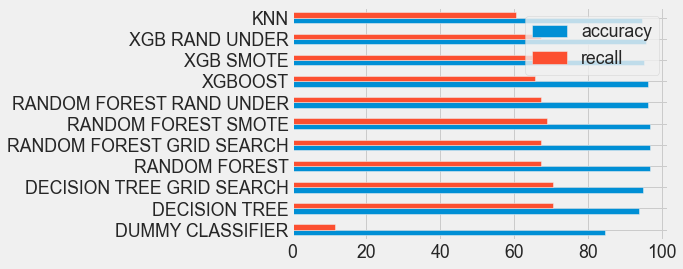

In [173]:
scores_df.plot(kind='barh')

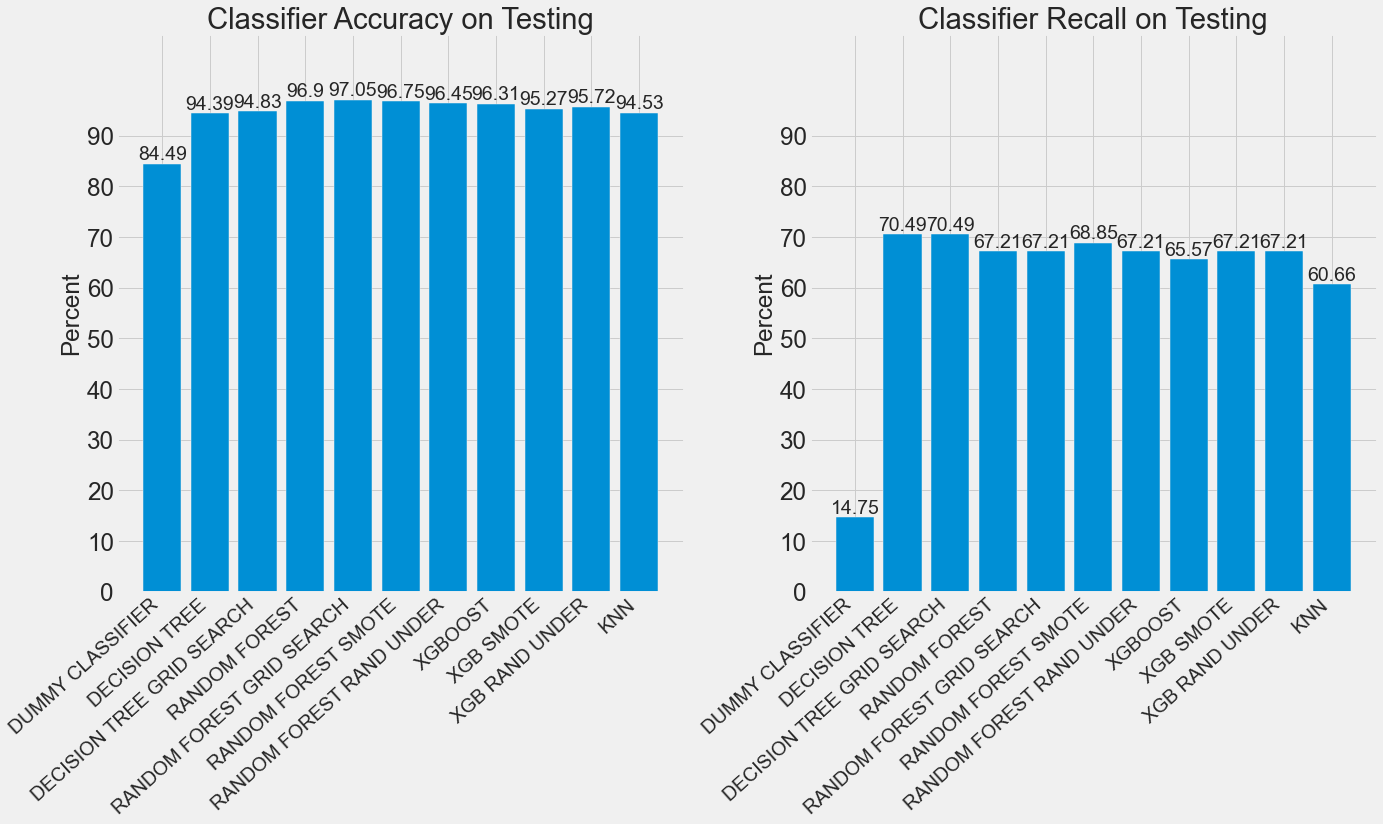

<Figure size 432x288 with 0 Axes>

In [214]:
width = 0.3
labels = scores_df.index
f_dict = {'fontsize': 20,
        'fontweight': 10,
        'horizontalalignment': 'right'}




fig, ax = plt.subplots(1,2, figsize=(20,12), dpi=70)
rect = ax[0].bar(scores_df.index, scores_df['accuracy'])
ax[0].set_ylabel('Percent', fontsize=25)
ax[0].set_title('Classifier Accuracy on Testing', fontsize=30)
ax[0].set_xticklabels(labels, fontsize=18, rotation=42, fontdict=f_dict)
ax[0].set_ylim(0,110)
ax[0].set_yticks(np.arange(0,100, 10))
ax[0].set_yticklabels(np.arange(0,100, 10), fontsize=25)

def autolabel(rects, ax_loc):
    for rect in rects:
        height = rect.get_height()
        ax[ax_loc].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

autolabel(rect, 0)

rect = ax[1].bar(scores_df.index, scores_df['recall'])
ax[1].set_ylabel('Percent', fontsize=25)
ax[1].set_title('Classifier Recall on Testing', fontsize=30)
ax[1].set_xticklabels(labels, fontsize=25, rotation=42, fontdict=f_dict)
ax[1].set_ylim(0,110)
ax[1].set_yticks(np.arange(0,100, 10))
ax[1].set_yticklabels(np.arange(0,100, 10), fontsize=25)

autolabel(rect, 1)

plt.tight_layout()
plt.show();

In [177]:
test_fsm_fpr, test_fsm_tpr, thresholds = roc_curve(y_test, bp.predict(X_test))
test_fsm_roc_auc = auc(test_fsm_fpr, test_fsm_tpr)
print('\nFSM roc-auc score: \n', test_fsm_roc_auc)

test_dtree_fpr, test_dtree_tpr, thresholds = roc_curve(y_test, dp.predict(X_test))
test_dtree_roc_auc = auc(test_dtree_fpr, test_dtree_tpr)
print('\nDecision Tree Classifier roc-auc score: \n', test_dtree_roc_auc)

test_dtree_grid_fpr, test_dtree_grid_tpr, thresholds = roc_curve(y_test, grid_dp.predict(X_test))
test_dtree_grid_roc_auc = auc(test_dtree_grid_fpr, test_dtree_grid_tpr)
print('\nDecision Tree Grid Search roc-auc score: \n', test_dtree_grid_roc_auc)

test_rf_fpr, test_rf_tpr, thresholds = roc_curve(y_test, rp.predict(X_test))
test_rf_roc_auc = auc(test_rf_fpr, test_rf_tpr)
print('\nRandom Forest Classifier roc-auc score: \n', test_rf_roc_auc)

test_grid_rf_fpr, test_grid_rf_tpr, thresholds = roc_curve(y_test, grid_rp.predict(X_test))
test_grid_rf_roc_auc = auc(test_grid_rf_fpr, test_grid_rf_tpr)
print('\nRandom Forest Grid Search roc-auc score: \n', test_grid_rf_roc_auc)

test_xg_fpr, test_xg_tpr, thresholds = roc_curve(y_test, xp.predict(X_test))
test_xg_roc_auc = auc(test_xg_fpr, test_xg_tpr)
print('\nXGBoost Classifier roc-auc score: \n', test_xg_roc_auc)

test_knn_fpr, test_knn_tpr, thresholds = roc_curve(y_test, kp.predict(X_test))
test_knn_roc_auc = auc(test_knn_fpr, test_knn_tpr)
print('\nK Nearest Neighbors Classifier roc-auc score: \n', test_knn_roc_auc)

test_smote_rf_fpr, test_smote_rf_tpr, thresholds = roc_curve(y_test, srp.predict(X_test))
test_smote_rf_roc_auc = auc(test_smote_rf_fpr, test_smote_rf_tpr)
print('\nRandom Forest with SMOTE roc-auc score: \n', test_smote_rf_roc_auc)

test_under_rf_fpr, test_under_rf_tpr, thresholds = roc_curve(y_test, urp.predict(X_test))
test_under_rf_roc_auc = auc(test_under_rf_fpr, test_under_rf_tpr)
print('\nRandom Forest with Random Undersampling roc-auc score: \n', test_under_rf_roc_auc)

test_smote_xg_fpr, test_smote_xg_tpr, thresholds = roc_curve(y_test, sxg.predict(X_test))
test_smote_xg_roc_auc = auc(test_smote_xg_fpr, test_smote_xg_tpr)
print('\nXGBoost Classifier with SMOTE roc-auc score: \n', test_smote_xg_roc_auc)

test_und_xg_fpr, test_und_xg_tpr, thresholds = roc_curve(y_test, uxg.predict(X_test))
test_und_xg_roc_auc = auc(test_und_xg_fpr, test_und_xg_tpr)
print('\nXGBoost Classifier with Random Under Sampling roc-auc score: \n', test_und_xg_roc_auc)


FSM roc-auc score: 
 0.4808388332978497

Decision Tree Classifier roc-auc score: 
 0.8329784969129232

Decision Tree Grid Search roc-auc score: 
 0.8386603150947414

Random Forest Classifier roc-auc score: 
 0.8352538854588035

Random Forest Grid Search roc-auc score: 
 0.8352538854588035

XGBoost Classifier roc-auc score: 
 0.8246220992122631

K Nearest Neighbors Classifier roc-auc score: 
 0.7927267404726421

Random Forest with SMOTE roc-auc score: 
 0.8418272301469022

Random Forest with Random Undersampling roc-auc score: 
 0.8320071322120504

XGBoost Classifier with SMOTE roc-auc score: 
 0.8263253140302322

XGBoost Classifier with Random Under Sampling roc-auc score: 
 0.828760378965297


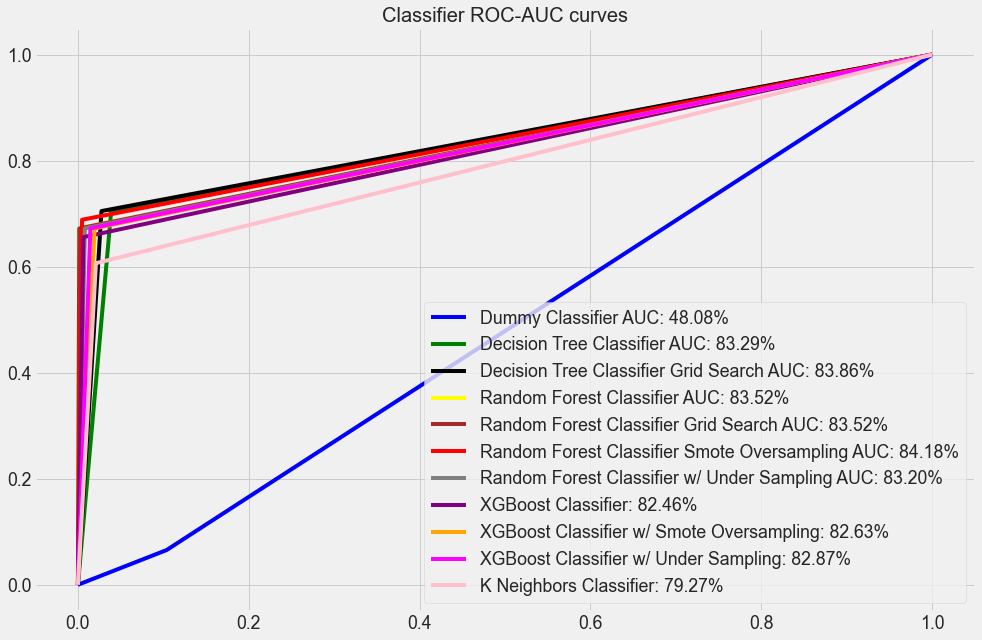

In [178]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))    
plt.plot(test_fsm_fpr, test_fsm_tpr, c='blue', label='Dummy Classifier AUC: 48.08%')
plt.plot(test_dtree_fpr, test_dtree_tpr, c='green', label='Decision Tree Classifier AUC: 83.29%')
plt.plot(test_dtree_grid_fpr, test_dtree_grid_tpr, c='black', label='Decision Tree Classifier Grid Search AUC: 83.86%')
plt.plot(test_rf_fpr, test_rf_tpr, c='yellow', label='Random Forest Classifier AUC: 83.52%')
plt.plot(test_grid_rf_fpr, test_grid_rf_tpr, c='brown', label='Random Forest Classifier Grid Search AUC: 83.52%')
plt.plot(test_smote_rf_fpr, test_smote_rf_tpr, c='red', label='Random Forest Classifier Smote Oversampling AUC: 84.18%')
plt.plot(test_under_rf_fpr, test_under_rf_tpr, c='grey', label='Random Forest Classifier w/ Under Sampling AUC: 83.20%')
plt.plot(test_xg_fpr, test_xg_tpr, c='purple', label='XGBoost Classifier: 82.46%')
plt.plot(test_smote_xg_fpr, test_smote_xg_tpr, c='orange', label='XGBoost Classifier w/ Smote Oversampling: 82.63%')
plt.plot(test_und_xg_fpr, test_und_xg_tpr, c='magenta', label='XGBoost Classifier w/ Under Sampling: 82.87%')
plt.plot(test_knn_fpr, test_knn_tpr, c='pink', label='K Neighbors Classifier: 79.27%')
plt.title('Classifier ROC-AUC curves', fontsize=20)
plt.legend(loc='best')

### Evaluation
- After fitting the classifiers to the entire training set and predicting on the test set, The Random Forest Classifier with SMOTE Oversampling achieved the highest ROC-AUC score at 84.18.
- The Decision Tree Classifier achieved the highest recall score on the testing data at 70.49% but had the lowest accuracy at 93%
- I believe the Random Forest Classifier with SMOTE Oversampling performed the best out of all the classifiers. The model achieved an accuracy score of 96.75 and a recall score of 68.85 on the test set.